In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import soundfile as sf
import librosa
import pandas as pd
import matplotlib.pyplot as plt

# Function to extract features from audio files
def extract_features(audio, sample_rate, mfcc=True, chroma=True, mel=True):
    features = []
    if chroma:
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        features.append(chroma_stft)
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        features.append(mfccs)
    if mel:
        mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
        features.append(mel_spectrogram)
    return np.hstack(features)

# Function to compute the fundamental frequency using librosa's YIN method
def compute_frequency(audio, sample_rate):
    pitches, magnitudes = librosa.core.piptrack(y=audio, sr=sample_rate)
    pitch = pitches[magnitudes > np.median(magnitudes)]
    if len(pitch) == 0:
        return 0
    return np.median(pitch)

# Function to calculate signal-to-noise ratio (SNR)
def calculate_snr(audio):
    signal_power = np.sum(audio ** 2) / len(audio)
    noise_power = np.sum((audio - np.mean(audio)) ** 2) / len(audio)
    return 10 * np.log10(signal_power / noise_power)

# Function to automatically label audio files based on frequency and SNR
def automatic_labeling(file_path):
    try:
        audio, sample_rate = sf.read(file_path)
        frequency = compute_frequency(audio, sample_rate)
        snr = calculate_snr(audio)
        print(f"File: {file_path}, Frequency: {frequency}, SNR: {snr}")  # Debug print
        # Adjust these thresholds according to your specific criteria
        if frequency > 100 and snr > 10:
            return "high_frequency_high_snr"
        elif frequency > 100 and snr <= 10:
            return "high_frequency_low_snr"
        elif frequency <= 100 and snr > 10:
            return "low_frequency_high_snr"
        else:
            return "low_frequency_low_snr"
    except Exception as e:
        print(f"Error in automatic_labeling for {file_path}: {e}")
        return None
#local data sample directory path

data_dir = "/content/sample_data"

# Lists to store features and labels
X = []
y = []

# Iterate through audio files and extract features
for filename in os.listdir(data_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(data_dir, filename)
        print(f"Processing file: {file_path}")
        label = automatic_labeling(file_path)
        if label is not None:
            audio, sample_rate = sf.read(file_path)
            features = extract_features(audio, sample_rate)
            if features is not None:
                X.append(features)
                y.append(label)
                print(f"Extracted features for file {file_path}")
            else:
                print(f"Features for file {file_path} are None")
        else:
            print(f"Label for file {file_path} is None")

# Check if X and y are empty
if len(X) == 0 or len(y) == 0:
    print("No features or labels extracted. Check your data and feature extraction process.")
else:
    # Convert features and labels to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Save features and labels to CSV in Google Drive
    save_dir = '/content/drive/MyDrive/Features'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    feature_columns = [f"feature_{i}" for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=feature_columns)
    df['label'] = y
    csv_path = os.path.join(save_dir, 'audio_features_labels.csv')
    df.to_csv(csv_path, index=False)
    print(f"Features and labels saved to {csv_path}")



Processing file: /content/sample_data/3.wav
File: /content/sample_data/3.wav, Frequency: 831.6485639362361, SNR: 7.83229982125723e-08
Extracted features for file /content/sample_data/3.wav
Processing file: /content/sample_data/13.wav
File: /content/sample_data/13.wav, Frequency: 705.3853372567015, SNR: 8.416650128068935e-12
Extracted features for file /content/sample_data/13.wav
Processing file: /content/sample_data/17.wav
File: /content/sample_data/17.wav, Frequency: 837.4039329509559, SNR: 5.0659076221940646e-08
Extracted features for file /content/sample_data/17.wav
Processing file: /content/sample_data/7.wav
File: /content/sample_data/7.wav, Frequency: 760.0547653670484, SNR: 5.254707154402957e-10
Extracted features for file /content/sample_data/7.wav
Processing file: /content/sample_data/2.wav
File: /content/sample_data/2.wav, Frequency: 583.5129943032221, SNR: 3.76220440358718e-08
Extracted features for file /content/sample_data/2.wav
Processing file: /content/sample_data/19.wav


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Path to the csv file dataset in Google Drive
csv_path = '/content/drive/MyDrive/Features/audio_features_labels.csv'

try:
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from {csv_path}")
except FileNotFoundError:
    print(f"File not found: {csv_path}")
    raise

# Separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# architecture
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_encoded.shape[1], activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Loaded dataset from /content/drive/MyDrive/Features/audio_features_labels.csv
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 3s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
1/1 [==============================] - 0s 32ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_a

Loaded dataset from /content/drive/MyDrive/Features/audio_features_labels.csv
Epoch [1/50], Train Loss: 0.5634, Test Loss: 0.0132
Epoch [2/50], Train Loss: 0.4889, Test Loss: 0.0176
Epoch [3/50], Train Loss: 0.5098, Test Loss: 0.0185
Epoch [4/50], Train Loss: 0.6670, Test Loss: 0.0148
Epoch [5/50], Train Loss: 0.4820, Test Loss: 0.0109
Epoch [6/50], Train Loss: 0.4913, Test Loss: 0.0102
Epoch [7/50], Train Loss: 0.4587, Test Loss: 0.0105
Epoch [8/50], Train Loss: 0.5095, Test Loss: 0.0123
Epoch [9/50], Train Loss: 0.5079, Test Loss: 0.0143
Epoch [10/50], Train Loss: 0.4768, Test Loss: 0.0164
Epoch [11/50], Train Loss: 0.4706, Test Loss: 0.0165
Epoch [12/50], Train Loss: 0.4587, Test Loss: 0.0186
Epoch [13/50], Train Loss: 0.4313, Test Loss: 0.0198
Epoch [14/50], Train Loss: 0.4603, Test Loss: 0.0171
Epoch [15/50], Train Loss: 0.4501, Test Loss: 0.0134
Epoch [16/50], Train Loss: 0.4306, Test Loss: 0.0106
Epoch [17/50], Train Loss: 0.4316, Test Loss: 0.0090
Epoch [18/50], Train Loss: 0.4

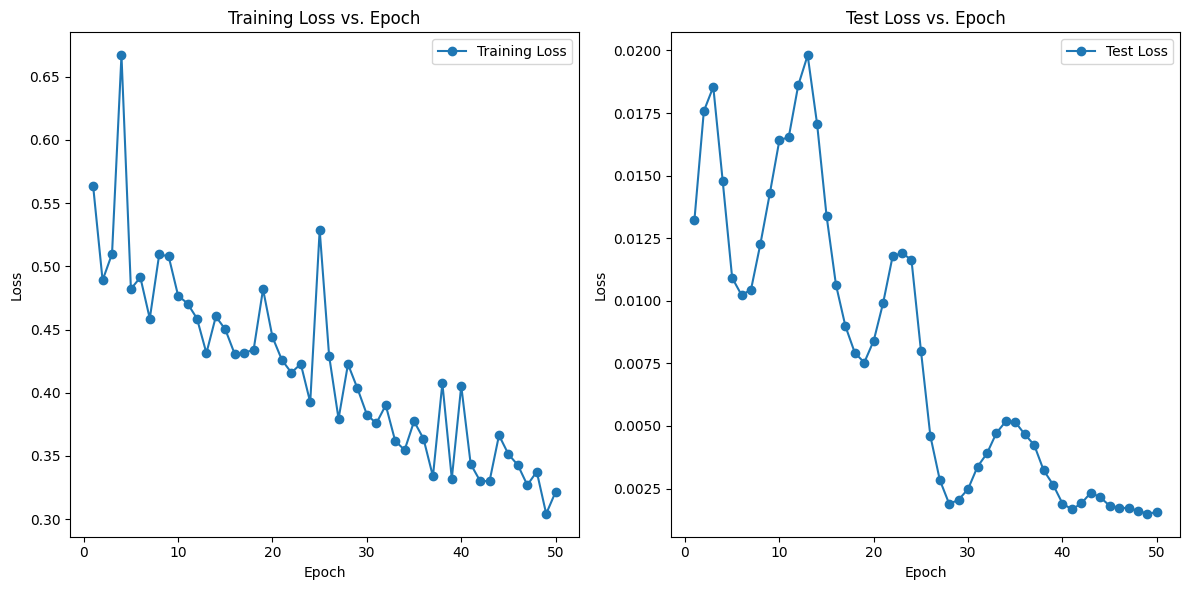

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

class SNREstimationModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.5, l2_reg=0.01):
        super(SNREstimationModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.l2_reg = l2_reg

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def l2_regularization_loss(self):
        l2_loss = 0.0
        for param in self.parameters():
            l2_loss += torch.norm(param, p=2)**2
        return 0.5 * self.l2_reg * l2_loss

# Path to the dataset in Google Drive
csv_path = '/content/drive/MyDrive/Features/audio_features_labels.csv'

try:
    df = pd.read_csv(csv_path)
    print(f"Loaded dataset from {csv_path}")
except FileNotFoundError:
    print(f"File not found: {csv_path}")
    raise

# Separate features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = torch.tensor(y_encoded, dtype=torch.float32).view(-1, 1)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = torch.tensor(X_scaled, dtype=torch.float32)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 256
model = SNREstimationModel(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
model.train()

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        l2_loss = model.l2_regularization_loss()
        total_loss = loss + l2_loss
        total_loss.backward()
        optimizer.step()
        epoch_train_loss += total_loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Evaluate on the test set
    model.eval()
    epoch_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()
    epoch_test_loss /= len(test_loader)
    test_losses.append(epoch_test_loss)
    model.train()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}')

# Plotting the training and test loss in separate graphs
plt.figure(figsize=(12, 6))

# Plot for training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.legend()

# Plot for test loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()
